# Hyperparameter Tuning

In [63]:
from sklearn.datasets import load_breast_cancer

# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Import batch normalization from keras layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve

We'll tune the hyperparameters of a binary classification model that does well classifying the breast cancer dataset.

In [3]:
data = load_breast_cancer()
cancer_data = data['data']
cancer_target = data['target']

In [4]:
print(f'Cancer Data:\n{cancer_data}')
print(f'Cancer Dataset Length: {len(cancer_data)}')
print(f'First row of Cancer Dataset: {(cancer_data[0])}')
print()
print(f'Target Variable:\n {cancer_target}')
print(f'Target Variable Dataset Length: {len(cancer_target)}')
print(f'First row of Target Variable Dataset: {(cancer_target[0])}')

Cancer Data:
[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
Cancer Dataset Length: 569
First row of Cancer Dataset: [1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]

Target Variable:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1

We'll define a simple `create_model()` function that creates a neural network for binary classificaiton; importantly it receives a learning rate and an activation function as arguments.

We've also imported the `Adam` optimizer as an object so that we can change its learning rate parameter.

In [55]:
# define a function that will create a model given an activation and learning rate
def create_model(learning_rate=0.01, activation='relu'):
	
	# create an Adam optimizer with the given learning rate
	opt = Adam(learning_rate=learning_rate)

	# create binary classification model  
	model = Sequential()

	# add an input shape of 30 for each of the features
	model.add(Input(shape=(30,)))
	model.add(Dense(128, activation = activation))
	model.add(Dense(256, activation = activation))
	model.add(Dense(1, activation = 'sigmoid'))

	# Compile model with optimizer, loss, and metrics
	model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
	
	return model

In [60]:
# create a KerasClassifier
model = KerasClassifier(build_fn=create_model,
                        verbose=0,
                        learning_rate=0.001,
                        activation='relu')

# define the parameters to try out
params = {'learning_rate': [0.1, 0.01, 0.001],
          'activation': ['relu', 'tanh'],
          'batch_size': [32, 128, 256],
          'epochs': [50, 100, 200]}

random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   cv=KFold(3),
                                   n_iter=100)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(cancer_data,
                                                    cancer_target,
                                                    test_size=0.2,
                                                    random_state=42)

random_search.fit(X_train, y_train)

print(f'Best parameters: {random_search.best_params_}')
print(f'Best cross-validation score: {random_search.best_score_}')

/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a f

Best parameters: {'learning_rate': 0.01, 'epochs': 200, 'batch_size': 32, 'activation': 'relu'}
Best cross-validation score: 0.938364122226095


The best performing best parameters are:
- `learning_rate`: 0.01
- `epochs`': 200
- `batch_size`: 32
- `activation`: 'relu

In [62]:
# get the best model
best_model = random_search.best_estimator_
best_model

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x147a11800>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	learning_rate=0.01
	activation=relu
	class_weight=None
)

In [64]:
# use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.956140350877193

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        43
           1       0.93      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
[[38  5]
 [ 0 71]]


Below we have all the results from the randomized search:

In [66]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,std_test_score,rank_test_score
7,"{'learning_rate': 0.01, 'epochs': 200, 'batch_...",0.938364,0.033132,1
17,"{'learning_rate': 0.001, 'epochs': 200, 'batch...",0.931756,0.036925,2
35,"{'learning_rate': 0.001, 'epochs': 200, 'batch...",0.929563,0.034900,3
16,"{'learning_rate': 0.01, 'epochs': 200, 'batch_...",0.927414,0.019664,4
22,"{'learning_rate': 0.01, 'epochs': 100, 'batch_...",0.925163,0.036156,5
2,"{'learning_rate': 0.001, 'epochs': 50, 'batch_...",0.922984,0.029953,6
44,"{'learning_rate': 0.001, 'epochs': 200, 'batch...",0.922970,0.038083,7
23,"{'learning_rate': 0.001, 'epochs': 100, 'batch...",0.920806,0.023762,8
19,"{'learning_rate': 0.01, 'epochs': 50, 'batch_s...",0.920777,0.033064,9
13,"{'learning_rate': 0.01, 'epochs': 100, 'batch_...",0.918555,0.042141,10


/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/eugene/Github/Deep-Learning-with-Keras/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a 

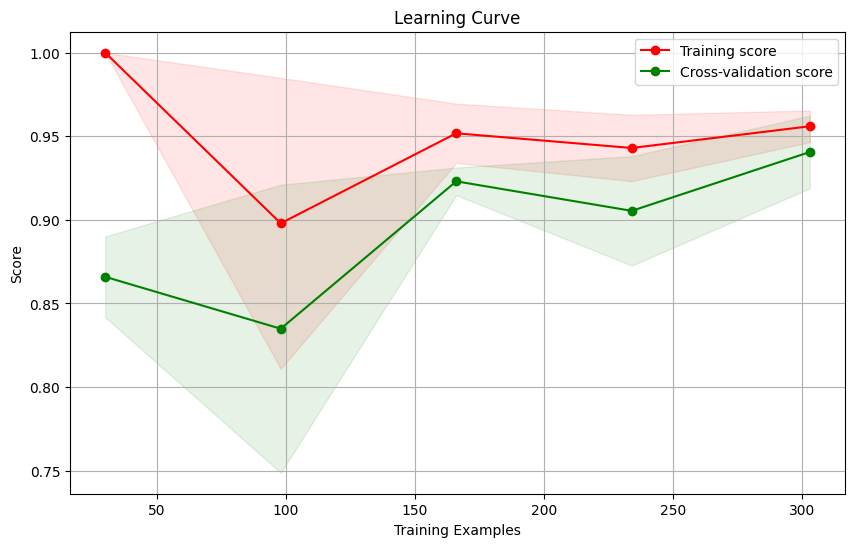

In [67]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                        X_train,
                                                        y_train,
                                                        cv=3, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()
